<a href="https://colab.research.google.com/github/Hani1-2/DeepLearningAssignmnt/blob/master/Text_classification_with_LSTM_tensorflow_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 212 kB 54.1 MB/s 


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [35]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [36]:
import pandas as pd
df = pd.read_csv('/content/Clean_Datasetmod.csv')

In [37]:
df_inputs = df[['text']]
df_target = df[['target']]

In [38]:
df_0_class = df_target == 0
df_1_class = df_target == 1 
df_0_class_undersampled = df_0_class.sample(df_1_class.shape[0])
df = pd.concat([df_0_class_undersampled, df_1_class], axis=0)

In [39]:
df.value_counts() 

target
False     5458
True      5458
dtype: int64

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_inputs,df_target, stratify=df_target)

## Tokenizer

Tokening the tweets

In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train.text) 
# tokenizer.fit_on_texts(X_test.text)

In [75]:
X_train.text[0]

'picture gunman inside lindt cafe martin place updates sydneysiege'

In [76]:
tweet = X_train.text[0]
tweet

'picture gunman inside lindt cafe martin place updates sydneysiege'

In [77]:
tokenizer.texts_to_sequences([tweet])

[[307, 33, 98, 111, 22, 156, 113, 147, 5]]

## Padding and Truncating Sequences



*   Checking length of the tweets
*   Creating padded sequences



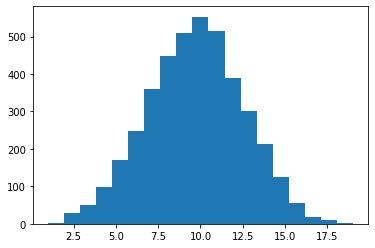

In [54]:
length = [len(t.split(' ')) for t in X_train.text]
plt.hist(length, bins = len(set(length)))
plt.show() # this shows that we minimum sentence comprising of 2.5 words and max 17 words

In [57]:
maxlen = 20
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [58]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=maxlen)
  return padded

In [78]:
padded_train_seq = get_sequences(tokenizer, X_train.text)

In [79]:
padded_train_seq[0]

array([  14,   25,  183, 1439,  414,   27, 1440,  438,   16,   53,  157,
        301,   83,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

## Creating the Model



*   creating model
*   compiling model



In [82]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
      tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss = 'binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 16)            160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 175,721
Trainable params: 175,721
Non-trainable params: 0
_________________________________________________________________


## Preparing Testing Set

In [84]:
padded_test_seq = get_sequences(tokenizer, X_test.text)

In [87]:
padded_test_seq[0], y_test.iloc[0]

(array([ 766,  647,  829,   96,   81, 1137, 3027,  475,  127,   23,    2,
         135,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 target    0
 Name: 4097, dtype: int64)

In [89]:
h = model.fit(
    padded_train_seq, y_train.target,
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 2)
    ]

)

Epoch 1/20
126/128 [============================>.] - ETA: 0s - loss: 0.4524 - accuracy: 0.7964

128/128 [==============================] - 20s 18ms/step - loss: 0.4506 - accuracy: 0.7977
Epoch 2/20
126/128 [============================>.] - ETA: 0s - loss: 0.1904 - accuracy: 0.9246

128/128 [==============================] - 2s 16ms/step - loss: 0.1912 - accuracy: 0.9245
Epoch 3/20
128/128 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9590

128/128 [==============================] - 2s 18ms/step - loss: 0.1120 - accuracy: 0.9590
Epoch 4/20
128/128 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9768

128/128 [==============================] - 2s 16ms/step - loss: 0.0678 - accuracy: 0.9768
Epoch 5/20
128/128 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9817

128/128 [==============================] - 2s 16ms/step - loss: 0.0512 - accuracy: 0.9817
Epoch 6/20
127/128 [============================>.] - ETA: 0s - loss: 0.0400 - accuracy: 0.9882

128/128 [==============================] - 2s 17ms/step - loss: 0.0404 - accuracy: 0.9880
Epoch 7/20
128/128 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9900

128/128 [==============================] - 2s 16ms/step - loss: 0.0333 - accuracy: 0.9900
Epoch 8/20
128/128 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9917

128/128 [==============================] - 2s 16ms/step - loss: 0.0274 - accuracy: 0.9917
Epoch 9/20
128/128 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9949

128/128 [==============================] - 2s 16ms/step - loss: 0.0182 - accuracy: 0.9949
Epoch 10/20
128/128 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9946

128/128 [==============================] - 2s 18ms/step - loss: 0.0192 - accuracy: 0.9946
Epoch 11/20
125/128 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9962

128/128 [==============================] - 2s 15ms/step - loss: 0.0155 - accuracy: 0.9963
Epoch 12/20
128/128 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9976

128/128 [==============================] - 2s 16ms/step - loss: 0.0111 - accuracy: 0.9976
Epoch 13/20
126/128 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9958

128/128 [==============================] - 2s 15ms/step - loss: 0.0156 - accuracy: 0.9958
Epoch 14/20
126/128 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9970

128/128 [==============================] - 2s 15ms/step - loss: 0.0113 - accuracy: 0.9971
Epoch 15/20
128/128 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9961

128/128 [==============================] - 2s 16ms/step - loss: 0.0116 - accuracy: 0.9961
Epoch 16/20
125/128 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9983

128/128 [==============================] - 2s 17ms/step - loss: 0.0100 - accuracy: 0.9980
Epoch 17/20
126/128 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9985

128/128 [==============================] - 2s 15ms/step - loss: 0.0069 - accuracy: 0.9985
Epoch 18/20
127/128 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9973

128/128 [==============================] - 2s 15ms/step - loss: 0.0112 - accuracy: 0.9973
Epoch 19/20
127/128 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9958

128/128 [==============================] - 2s 16ms/step - loss: 0.0120 - accuracy: 0.9958
Epoch 20/20
127/128 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.9973

128/128 [==============================] - 2s 15ms/step - loss: 0.0081 - accuracy: 0.9971


## Evaluating the Model

In [91]:
_ = model.evaluate(padded_test_seq, y_test.target)

43/43 [==============================] - 3s 8ms/step - loss: 0.6953 - accuracy: 0.8703


In [93]:
preds = model.predict(padded_test_seq)